In [2]:
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import sys, tqdm
from scipy.interpolate import interp1d, griddata
from scipy.optimize import fsolve


import numpy.ma as ma

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


sys.path.append('../pipeline_scripts/')
from pipeline_main import pipeline, sinks
from plotting_setup import *

In [9]:
data = pipeline(snap = 348, run = 'sink13fmr05', sink_id=13)
data.recalc_L(verbose = 1, radius = 10 ); data.calc_trans_xyz(verbose = 0)

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:06<00:00, 625.37it/s]


Converged mean angular momentum vector after 1 iteration(s)


100%|██████████| 4165/4165 [00:01<00:00, 2844.53it/s]


In [4]:
shell_r=50; shell_Δpct=0.05

shell_r /= data.au_length
Δ_r = np.maximum(shell_Δpct * shell_r, 2.5 * 0.5 ** data.lmax) 

patch_coord = []
patch_values = []
patch_mass = []
cell_level = []

pp = [p for p in data.sn.patches if (p.dist_xyz < shell_r * 2).any() and p.level > 5]
w = np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

for p in tqdm.tqdm(sorted_patches, disable=(not data.loading_bar)):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position) ** 2).sum() < (p.size ** 2).sum() / 12]
    if len(leafs) == 8: continue
    to_extract = (p.dist_xyz < shell_r + Δ_r) & (p.dist_xyz > shell_r - Δ_r)
    for lp in leafs:
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all(((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None])), axis=0)
        to_extract *= covered_bool

    new_xyz = p.trans_xyz[:, to_extract].T
    new_value = (p.var('d') * np.sum((p.trans_vrel *  p.trans_xyz / np.linalg.norm(p.trans_xyz, axis=0)), axis=0))[to_extract].T
    mass = p.m[to_extract].T

    patch_values.extend(new_value.tolist())
    patch_mass.extend(mass.tolist())
    patch_coord.extend(new_xyz.tolist())
    cell_level.extend(p.level * np.ones(len(mass)))

patch_values = np.asarray(patch_values)
patch_mass = np.asarray(patch_mass)
cell_level = np.asarray(cell_level)
patch_coord = np.array(patch_coord)

100%|██████████| 961/961 [00:00<00:00, 1677.35it/s]


In [5]:
avg_cell_level = np.rint(cell_level.mean()); print(avg_cell_level)

20.0


In [6]:
shell_r

6.0596241088788074e-05

In [8]:
avg_cell_level

20.0

In [7]:
nside = int(np.rint(fsolve(lambda x: hp.nside2resol(x) * shell_r - 0.5**avg_cell_level , 40)[0]))
nside

65

In [60]:
nside =75; npix = hp.nside2npix(nside); m_data = np.zeros(npix)
print('Number of pixels on the sphere: ',npix)
pixel_indices = hp.vec2pix(nside, patch_coord[:,0], patch_coord[:,1], patch_coord[:,2])
index, counts = np.unique(pixel_indices, return_counts=True); 
m = np.zeros(npix)
m[index] = counts
print('Pixels without any representation: ', np.sum(m == 0))
print('Percentage of no-coverage: ', np.sum(m == 0) / npix * 100,'%' )

Number of pixels on the sphere:  67500
Pixels without any representation:  17885
Percentage of no-coverage:  26.496296296296297 %


## Average overrepresented pixels 

In [29]:
pix2angle(nside, ipix=0, jpix=1, each2each=True)

array([[0.02565966]])

In [39]:
0.5**data.lmax * data.au_length

0.7869088076015207

In [51]:
hp.nside2resol(65) *50

0.7871743907280682

In [79]:
radius = 200 / data.au_length


In [80]:
nside

65.0

In [77]:
cell_area = hp.nside2pixarea(nside) * shell_r**2
sum_value = np.bincount(pixel_indices, weights=patch_values) 
sum_count = np.bincount(pixel_indices)
map_clean = np.zeros(npix)
map_clean[sum_count > 0] = sum_value[sum_count > 0] / sum_count[sum_count > 0]



ValueError: The weights and list don't have the same length.

In [12]:
sum_count

array([0, 0, 0, ..., 0, 1, 4])

In [11]:
cell_area 

7.595475222928456e-14

## Interpolate missing values

In [149]:
hp.pix2ang(npix, 1)

(1.3885996274392616e-05, 2.356194490192345)

In [150]:
hp.get_interp_weights(nside, 1)

(array([1, 2, 6, 7]), array([1., 0., 0., 0.]))

In [151]:
map_inter1 = map_clean.copy()
map_inter1[map_clean == 0] = hp.get_interp_val(map_clean, *hp.pix2ang(npix, np.where(map_clean == 0)))


In [152]:
mask = (map_clean == 0) 
inter_func = interp1d(np.arange(npix)[~mask], map_clean[~mask], kind = 'linear', fill_value= 'extrapolate')
map_inter2 = inter_func(np.arange(npix))

In [153]:
map_inter3 = map_clean.copy()
all_neighbours = hp.get_all_neighbours(nside, np.where(map_inter3 == 0))

for i, index in enumerate(np.where(map_inter3 == 0)[0]):
    non_zero_neighbours = all_neighbours[:,0,i] > 0
    map_inter3[index] = np.average(map_inter3[all_neighbours[:,0,i]], weights = non_zero_neighbours)


In [154]:
map_real1 = map_inter1 * -data.msun_mass / data.sn.cgs.yr * cell_area

map_real2 = map_inter2 * -data.msun_mass / data.sn.cgs.yr * cell_area

map_real3 = map_inter3 * -data.msun_mass / data.sn.cgs.yr * cell_area

<Figure size 1200x800 with 0 Axes>

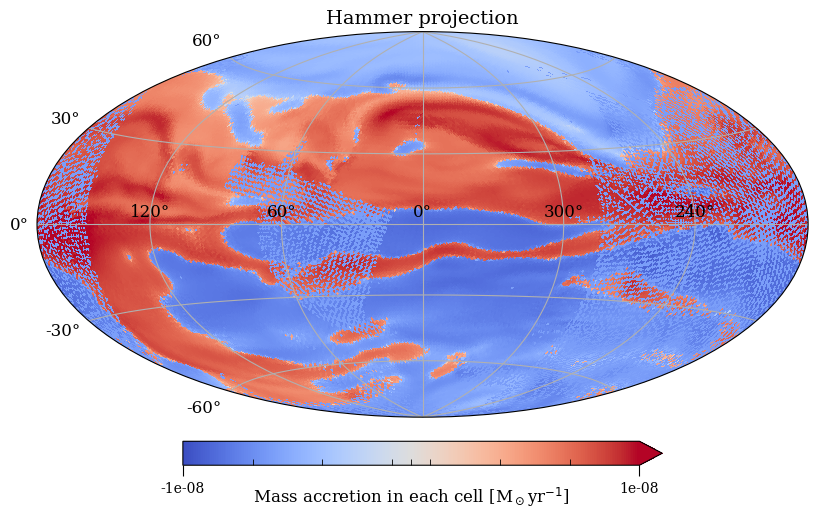

In [155]:
fig = plt.figure(figsize = (12,8)) 
ax = projview(
    map_real1,
    norm = 'symlog',
    max = 1e-8,
    min = -1e-8,
    norm_dict = {'linthresh': 1e-14, 'linscale': 0.5},
    coord=["G"],
    cmap = 'coolwarm',
    flip = 'astro',
    graticule=True,
    graticule_labels=True,
    cb_orientation="horizontal",
    rot = (0, 180),
    #latitude_grid_spacing=30,
    projection_type="hammer",
    title="Hammer projection",
    unit = r'Mass accretion in each cell [M$_\odot$yr$^{-1}$]'
);


<Figure size 1200x800 with 0 Axes>

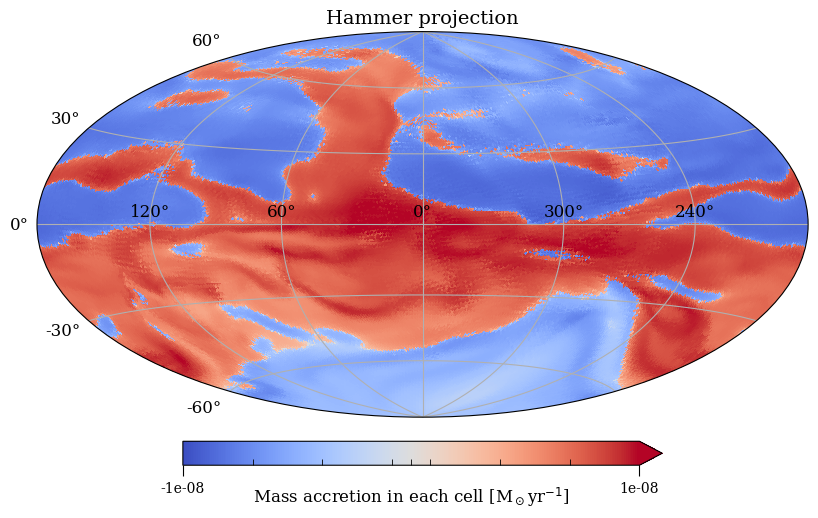

In [159]:
fig = plt.figure(figsize = (12,8)) 
ax = projview(
    map_real2,
    norm = 'symlog',
    max = 1e-8,
    min = -1e-8,
    norm_dict = {'linthresh': 1e-14, 'linscale': 0.5},
    coord=["G"],
    cmap = 'coolwarm',
    flip = 'astro',
    graticule=True,
    graticule_labels=True,
    cb_orientation="horizontal",
    #latitude_grid_spacing=30,
    projection_type="hammer",
    title="Hammer projection",
    unit = r'Mass accretion in each cell [M$_\odot$yr$^{-1}$]'
);


In [157]:
np.sum(map_real2), np.sum(map_real3)

(2.4925023336862407e-05, 2.3259980955763405e-05)

<Figure size 1200x800 with 0 Axes>

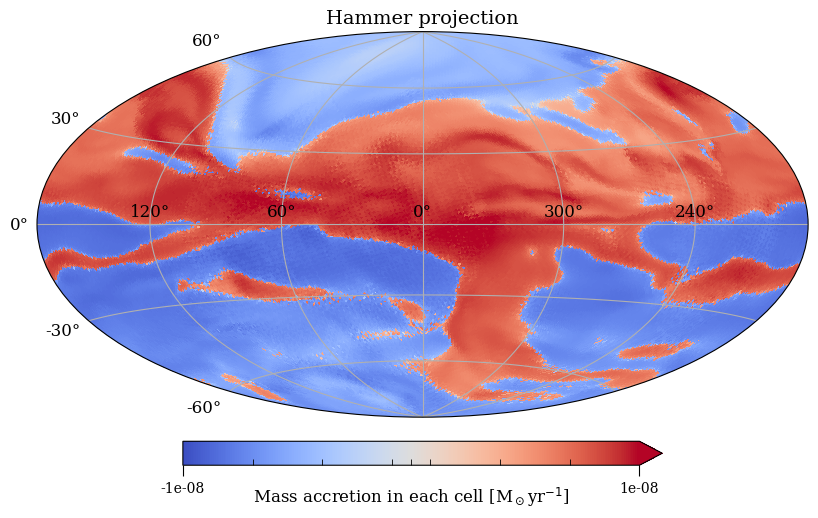

In [166]:
fig = plt.figure(figsize = (12,8)) 
ax = projview(
    map_real3,
    norm = 'symlog',
    max = 1e-8,
    min = -1e-8,
    norm_dict = {'linthresh': 1e-14, 'linscale': 0.5},
    coord=["G"],
    cmap = 'coolwarm',
    graticule=True,
    graticule_labels=True,
    cb_orientation="horizontal",
    rot = (180,180),
    #latitude_grid_spacing=30,
    projection_type="hammer",
    title="Hammer projection",
    unit = r'Mass accretion in each cell [M$_\odot$yr$^{-1}$]'
);
